# Autor: Gilson Machado

# **Desafio 7: Crie um modelo de análise das métricas RFV**

## **Contexto:**
Você foi contratado por uma empresa de e-commerce que está buscando entender
melhor o comportamento de seus clientes para personalizar as suas campanhas de
marketing. Para isso, a empresa disponibilizou uma base de dados em csv contendo
dados sobre clientes, produtos e transações da loja realizadas entre os anos de 2010 e
2011.
Com base nesses dados, você precisa agrupar os clientes em clusters com base em
seu comportamento de compra. Isso irá permitir identificar padrões e características em
comum entre os clientes, como:

- Clientes que compram os mesmos produtos;

- Clientes que possuem a mesma frequência de compras;

- Clientes que gastam mais dinheiro em suas compras.

A partir desses clusters, gere insights para que a empresa possa segmentar melhor a
sua base de clientes e personalizar as suas campanhas de marketing, direcionando
promoções e ofertas aos clientes com base no comportamento de compras.

# Etapas de Desenvolvimento

## Análise exploratória dos dados

#### A análise exploratória é fundamental para entender a estrutura dos dados e identificar padrões e relações entre as variáveis. Nessa etapa, estamos utilizando bibliotecas como matplotlib e seaborn para visualizar as distribuições das variáveis e verificar a presença de dados nulos, duplicados, outliers e inconsistências.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, scale, PowerTransformer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from yellowbrick.cluster import kelbow_visualizer
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance, kelbow_visualizer, silhouette_visualizer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

- Carregando Base de Dados

In [2]:
df = pd.read_csv('data.csv', sep=',', encoding='ISO-8859-1')

- Descrição estatística dos dados

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    535874 non-null  object 
 2   Description  534420 non-null  object 
 3   Quantity     535874 non-null  float64
 4   InvoiceDate  535874 non-null  object 
 5   UnitPrice    535874 non-null  float64
 6   CustomerID   403182 non-null  float64
 7   Country      535874 non-null  object 
dtypes: float64(3), object(5)
memory usage: 33.1+ MB


In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,535874.000000,535874.000000,403182.000000
mean,9.587927,4.636533,15287.687868
std,153.292222,97.302232,1714.009551
min,-74215.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13952.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,74215.000000,38970.000000,18287.000000


In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
df.isna().sum().sort_values(ascending=False)

,0
CustomerID,138727
Description,7489
StockCode,6035
Quantity,6035
InvoiceDate,6035
UnitPrice,6035
Country,6035
InvoiceNo,0


Visualizando as distribuições e identificando a relevância das colunas para a análise.

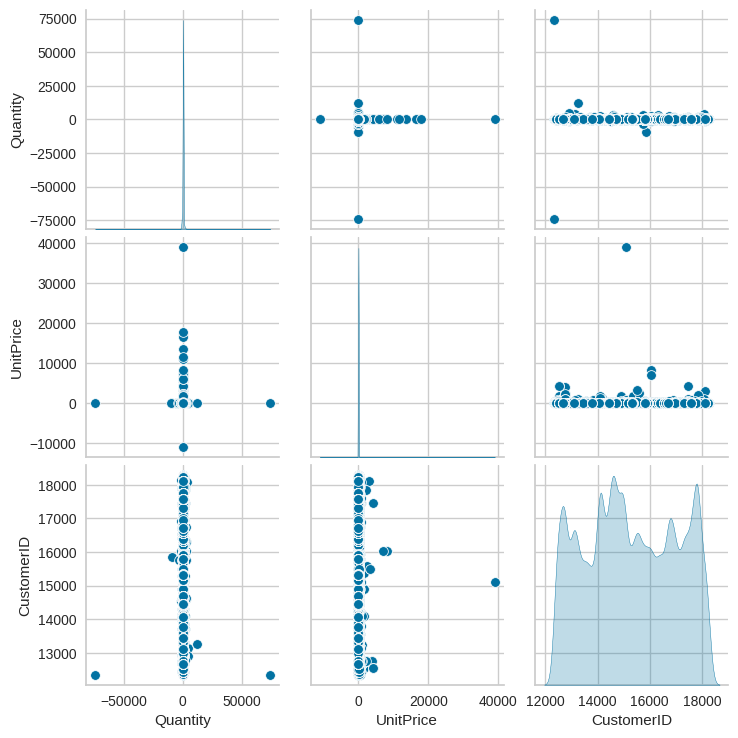

In [9]:
sns.pairplot(df, diag_kind='kde')
plt.show()

- Verificando a presença de dados nulos, duplicados, outliers e demais inconsistências nos dados.

In [10]:
# Identificando valores nulos
(
    df.isna().sum()
    .to_frame("Valores_nulos")
    .assign(missing_pct=lambda x: (x.div(len(df)) * 100).round(2))
    .sort_values("Valores_nulos", ascending=False)
)

,Valores_nulos,missing_pct
CustomerID,138727,25.60
Description,7489,1.38
StockCode,6035,1.11
Quantity,6035,1.11
InvoiceDate,6035,1.11
UnitPrice,6035,1.11
Country,6035,1.11
InvoiceNo,0,0.00


In [11]:
# Checando se há registros duplicados
df.duplicated().any()

True

## Pré-processamento dos dados

#### O pré-processamento dos dados é uma etapa crucial no processo de análise de dados que envolve a preparação dos dados para a análise.

In [12]:
# Removendo os registros da coluna 'Country', durante a verificação na etapa anterior foi identificado registros inválidos.
df = df[df['Country']!="Unspecified"]
df['Country'].value_counts()

,count
Country,
United Kingdom,489721
Germany,9448
France,8525
EIRE,8138
Spain,2513
Netherlands,2355
Belgium,2060
Switzerland,1991
Portugal,1514


In [13]:
# Checando se há registros igual ou menor que zero em 'UnitPrice'
from typing import Counter
Counter(df[df['UnitPrice'] <=0 | df['UnitPrice'].isnull()].count())

Counter({2500: 6, 1046: 1, 40: 1})

In [14]:
# Aplicando filtro no dataframe para considerar somente os registros acima de 0
df = df[df['UnitPrice'] > 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 532930 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    532930 non-null  object 
 1   StockCode    532930 non-null  object 
 2   Description  532930 non-null  object 
 3   Quantity     532930 non-null  float64
 4   InvoiceDate  532930 non-null  object 
 5   UnitPrice    532930 non-null  float64
 6   CustomerID   402900 non-null  float64
 7   Country      532930 non-null  object 
dtypes: float64(3), object(5)
memory usage: 36.6+ MB


In [15]:
# Aplicando filtro no dataframe para considerar somente os registros acima de 0
df = df[df['Quantity'] > 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 523709 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    523709 non-null  object 
 1   StockCode    523709 non-null  object 
 2   Description  523709 non-null  object 
 3   Quantity     523709 non-null  float64
 4   InvoiceDate  523709 non-null  object 
 5   UnitPrice    523709 non-null  float64
 6   CustomerID   394061 non-null  float64
 7   Country      523709 non-null  object 
dtypes: float64(3), object(5)
memory usage: 36.0+ MB


In [16]:
# Remover valores duplicados
df.drop_duplicates(inplace=True)

- Realizando a normalização dos dados.

In [17]:
# Transformando o type'CustomerID' para inteiro
df['CustomerID'] = df['CustomerID'].fillna(0).astype(int)

In [18]:
# Transformando o type'InvoiceDate' para data
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [19]:
# Checando o dtype
df[['CustomerID','InvoiceDate']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 518532 entries, 0 to 541908
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   CustomerID   518532 non-null  int64         
 1   InvoiceDate  518532 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.9 MB


In [20]:
# Aplicando filtro para 'Quantity' até 10000, removendo os outliers acima de 10.000
df = df[df['Quantity'] <= 10000]

In [21]:
# Aplicando filtro para 'UnitPrice' até 5000, removendo os outliers acima de 5.000
df = df[df['UnitPrice'] <= 5000]

In [22]:
# Configurando a data para ano - mes - dia
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

- Plotandos dados normalizados

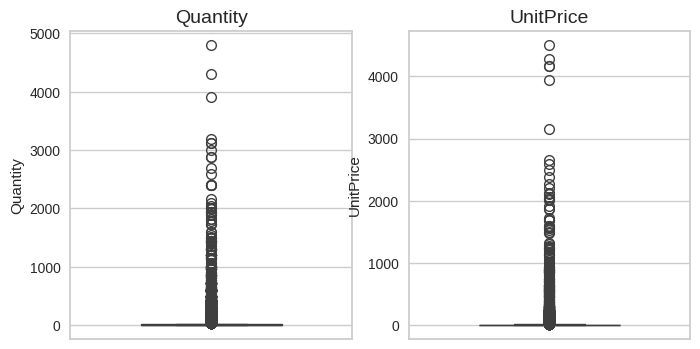

In [28]:
# Plotando os boxplots
plt.figure(figsize=(8, 4))

# Boxplot para Quantity
sns.boxplot(y='Quantity', data=df, color='#1f77b4', width=0.5, ax=plt.subplot(1, 2, 1))
plt.title('Quantity', fontsize=14)

# Boxplot para UnitPrice
sns.boxplot(y="UnitPrice", data=df, color='#1f77b4', width=0.5, ax=plt.subplot(1, 2, 2))
plt.title('UnitPrice', fontsize=14)

# Mostrando o gráfico
plt.show()

In [29]:
# Criando uma nova coluna, com o valor total da compra, multiplicando a 'Quantity' pelo 'UnitPrice'
df['TotalCompra'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalCompra,DataUltimaCompra
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01,2.55,17850,United Kingdom,15.30,2011-12-09
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01,3.39,17850,United Kingdom,20.34,2011-12-09
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01,2.75,17850,United Kingdom,22.00,2011-12-09
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01,3.39,17850,United Kingdom,20.34,2011-12-09
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01,3.39,17850,United Kingdom,20.34,2011-12-09


In [30]:
# A nova coluna "DataUltimacompra" vai ajudar no cálculo da recência.
df['DataUltimaCompra'] = df['InvoiceDate'].max()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalCompra,DataUltimaCompra
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01,2.55,17850,United Kingdom,15.30,2011-12-09
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01,3.39,17850,United Kingdom,20.34,2011-12-09
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01,2.75,17850,United Kingdom,22.00,2011-12-09
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01,3.39,17850,United Kingdom,20.34,2011-12-09
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01,3.39,17850,United Kingdom,20.34,2011-12-09


#### Cálculo do RFM
R é a recência, diferença em dias da última compra do cliente e da última compra disponível no conjunto de dados, que calcularam previamente.

F é a frequência, ou seja, a quantidade de compras feitas pelo cliente;

M é o ticket médio, ou seja, a média das compras feitas pelo cliente.

In [31]:
data_atual = df['DataUltimaCompra'].max()

rfm = df.groupby('InvoiceNo').agg(
    Recencia=('InvoiceDate', lambda dates: (data_atual - dates.max()).days),
    Frequencia=('InvoiceDate', 'size'),
    TicketMedio=('TotalCompra', 'mean')
).reset_index()

rfm.head()

,InvoiceNo,Recencia,Frequencia,TicketMedio
0,536365,373,7,19.874286
1,536366,373,2,11.100000
2,536367,373,12,23.227500
3,536368,373,4,17.512500
4,536369,373,1,17.850000


In [85]:
rfm = rfm[rfm['TicketMedio'] < 6000]

####Seleção das variáveis mais relevantes para o modelo.
Definindo X para aplicar o modelo K-means para clusterização das respectivas variáveis:

Recencia, Frequência e TicketMedio.

## Selecionando o algoritmo de clusterização

#### - Para esse projeto vou ultilizar o K-Means, por várias razões, uma das principais vantagens é sua simplicidade e facilidade de implementação. Além disso, é relativamente rápido e eficiente, tornando-o adequado para grandes conjuntos de dados. Além disso, o k-means é um algoritmo versátil que pode ser usado para uma ampla variedade de tarefas de clusterização, desde segmentação de clientes até classificação de imagens.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

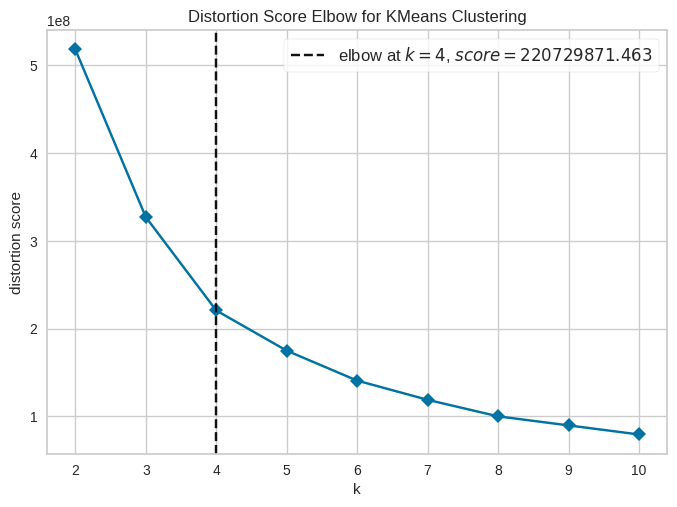

In [55]:
X = rfm[['Recencia', 'Frequencia', 'TicketMedio']]
kelbow_visualizer(KMeans(), X, k=10, timings=False);

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


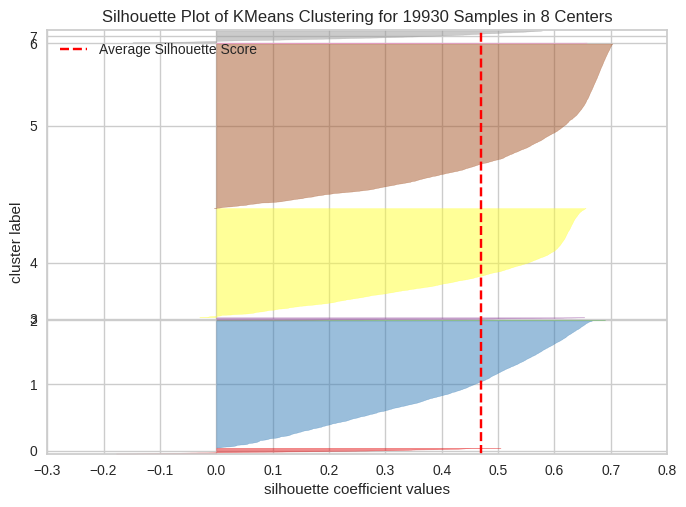

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 19930 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     estimator=KMeans())

In [35]:
silhouette_visualizer(KMeans(), X)

- Número de Clusters

In [67]:
n_clusters = 4

- Aplicando o algoritimo escolhido no conjunto de dados.

In [37]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)
y_pred = kmeans.predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Análise dos clusters obtidos.

In [49]:
# DataFrame com uma coluna a mais, agora com os dados já crusterizados.
rfm['dados_clusterizados'] = y_pred

In [70]:
# Visualização 3D dos clusters
px.scatter_3d(rfm, x='Recencia', y='Frequencia', z='TicketMedio', color=rfm['dados_clusterizados'].astype(str), template='plotly_dark')

In [84]:
X['cluster'] = rfm['dados_clusterizados']  # Adicionando a coluna 'cluster' ao DataFrame X

# Calculando a média das variáveis para cada cluster
X.groupby('cluster').mean().transpose().style.background_gradient(cmap='YlOrRd', axis=1)

<ipython-input-84-34778bbb0821>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cluster,0,1,2,3
Recencia,71.530412,268.671126,156.799331,158.384615
Frequencia,28.003819,24.573966,3.555184,2.307692
TicketMedio,32.175390,33.345039,754.632867,2870.638369


### Interpretação dos resultados obtidos

# Interpretação dos resultados obtidos


## Descrição do perfil de compras dos clientes por cluster

- #### Cluster 0: Os clientes deste cluster têm uma recência média de 71 dias, o que significa que eles fazem compras frequentemente. Além disso, eles têm uma frequência média de 28 compras e um ticket médio de R$ 32. Esses clientes são frequentes e fazem compras de valor relativamente baixo.

- #### Cluster 1: Os clientes deste cluster têm uma recência média de 268 dias, o que significa que eles fazem compras menos frequentemente. Além disso, eles têm uma frequência média de 24 compras e um ticket médio de R$ 33. Esses clientes são menos frequentes e fazem compras de valor relativamente baixo.

- #### Cluster 2: Os clientes deste cluster têm uma recência média de 156 dias, o que significa que eles fazem compras moderadamente frequentes. Além disso, eles têm uma frequência média de 3 compras e um ticket médio de R$ 754. Esses clientes são menos frequentes e fazem compras de valor relativamente alto.

- #### Cluster 3: Os clientes deste cluster têm uma recência média de 158 dias, o que significa que eles fazem compras moderadamente frequentes. Além disso, eles têm uma frequência média de 2 compras e um ticket médio de R$ 2870. Esses clientes são menos frequentes e fazem compras de valor muito alto.



## Como a análise pode ser útil para empresa na segmentação de seus clientes e personalização das campanhas de marketing.

### Essa análise pode ser útil para a empresa em várias maneiras:
- #### Segmentação de clientes: A empresa pode segmentar seus clientes em quatro grupos com base nos seus padrões de compra, o que permite uma abordagem mais personalizada e eficaz em suas campanhas de marketing.
- #### Personalização de ofertas: A empresa pode oferecer ofertas personalizadas para cada cluster, por exemplo, ofertas de desconto para os clientes do Cluster 0 que fazem compras frequentes, ou ofertas de produtos de alto valor para os clientes do Cluster 3 que fazem compras de valor alto.
- #### Foco em clientes de alto valor: A empresa pode focar em manter e agradar os clientes do Cluster 3, que fazem compras de valor muito alto, para garantir que eles continuem a fazer compras na loja.
- #### Aumento da frequência de compras: A empresa pode criar estratégias para aumentar a frequência de compras dos clientes do Cluster 1 e 2, que fazem compras menos frequentes.

## Possiveis ações a serem realizadas

- #### Criar campanhas de email marketing personalizadas para cada cluster, com ofertas e conteúdo relevantes para cada grupo de clientes.
- #### Desenvolver programas de fidelidade para os clientes do Cluster 0 e 1, para incentivá-los a fazer mais compras.
- #### Oferecer produtos de alto valor e exclusivos para os clientes do Cluster 3, para manter sua satisfação e fidelidade.
-#### Criar estratégias de upselling e cross-selling para os clientes do Cluster 2, para aumentar o valor médio das suas compras.
- #### Realizar análises adicionais para entender melhor as características e comportamentos dos clientes de cada cluster, para desenvolver estratégias mais eficazes de marketing e vendas.